<a href="https://colab.research.google.com/github/jgarciad/MMM-Model/blob/main/ModeloMMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyMC Marketing imports
from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
    MMM,
)
import arviz as az

# Analysis imports
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("📊 MMM Completo - Análisis de Mix de Medios")
print("=" * 60)


📊 MMM Completo - Análisis de Mix de Medios


In [ ]:
# =============================================================================
# 1. CARGA Y PREPARACIÓN MEJORADA DE DATOS
# =============================================================================

df = pd.read_csv('DATA_SET_FINAL.csv')

# Convertir fecha y crear features temporales
df['date_week'] = pd.to_datetime(df['fecha'])
df = df.sort_values('date_week').reset_index(drop=True)

# Crear features temporales adicionales
df['dayofweek'] = df['date_week'].dt.dayofweek
df['month'] = df['date_week'].dt.month
df['week_of_year'] = df['date_week'].dt.isocalendar().week
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

print(f"📈 Dataset cargado: {len(df)} observaciones")
print(f"📅 Período: {df['date_week'].min().strftime('%Y-%m-%d')} a {df['date_week'].max().strftime('%Y-%m-%d')}")



📈 Dataset cargado: 120 observaciones
📅 Período: 2025-01-01 a 2025-04-30


In [ ]:
# =============================================================================
# 2. DEFINIR TODOS LOS CANALES DE MEDIA DISPONIBLES
# =============================================================================

# Canales de media pagada - TODOS los disponibles en tu dataset
paid_media_channels = {
    'email': 'inversion_email',
    'bing': 'bing_cost',
    'dv360': 'DV360_cost',
    'google': 'google_cost',
    'meta': 'meta_cost',
    'tiktok': 'tictok_cost',  # Nota: hay typo en tu dataset
    'tv': 'tv_spend',
    'radio': 'radio_spend'
}

# Verificar qué canales tienen datos
available_channels = {}
for channel, column in paid_media_channels.items():
    if column in df.columns and df[column].sum() > 0:
        available_channels[channel] = column
        print(f"✅ {channel}: {df[column].sum():,.0f} total spend")
    else:
        print(f"❌ {channel}: Sin datos o columna no encontrada")

print(f"\n🎯 Canales activos para MMM: {list(available_channels.keys())}")


✅ email: 640,196 total spend
✅ bing: 964,131 total spend
✅ dv360: 5,233,544 total spend
✅ google: 27,857,033 total spend
✅ meta: 21,100,547 total spend
✅ tiktok: 2,326,450 total spend
✅ tv: 94,453,788 total spend
✅ radio: 36,515,477 total spend

🎯 Canales activos para MMM: ['email', 'bing', 'dv360', 'google', 'meta', 'tiktok', 'tv', 'radio']


In [ ]:
# =============================================================================
# 3. PREPARAR VARIABLES SIGUIENDO CONVENCIÓN DE DOCS
# =============================================================================

# Crear variables de canal siguiendo convención x1, x2, etc.
channel_mapping = {}
for i, (channel, column) in enumerate(available_channels.items(), 1):
    var_name = f'x{i}'
    df[var_name] = df[column]
    channel_mapping[var_name] = channel

channel_columns = list(channel_mapping.keys())

# Variable target (ventas totales)
df['y'] = (df['venta_tienda_fisica'] +
           df['venta_terceros'] +
           df['venta_online'])

# Variables de control mejoradas
df['t'] = range(len(df))  # Trend

# Control: Total de tickets (proxy de tráfico/demanda base)
df['total_tickets'] = (df['tickets_tienda_fisica'] +
                      df['tickets_terceros'] +
                      df['tickets_online'])

# Control: Clientes únicos totales
df['total_unique_customers'] = (df['ClientesUnicosIdentificados_tienda_fisica'] +
                               df['ClientesUnicosIdentificados_terceros'] +
                               df['ClientesUnicosIdentificados_online'])

# Control: Estacionalidad semanal
df['sin_week'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['cos_week'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

# Normalizar variables de control
scaler = MinMaxScaler()
control_vars = ['total_tickets', 'total_unique_customers', 'sin_week', 'cos_week']
df[control_vars] = scaler.fit_transform(df[control_vars])

control_columns = ['t'] + control_vars + ['is_weekend']

print(f"📋 Variables preparadas:")
print(f"   Canales: {channel_columns} -> {list(channel_mapping.values())}")
print(f"   Controles: {control_columns}")


📋 Variables preparadas:
   Canales: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'] -> ['email', 'bing', 'dv360', 'google', 'meta', 'tiktok', 'tv', 'radio']
   Controles: ['t', 'total_tickets', 'total_unique_customers', 'sin_week', 'cos_week', 'is_weekend']


In [ ]:
# =============================================================================
# 4. ANÁLISIS EXPLORATORIO COMPLETO
# =============================================================================

print("\n" + "="*60)
print("📊 ANÁLISIS EXPLORATORIO DETALLADO")
print("="*60)

# Preparar datos para análisis
X = df[['date_week'] + channel_columns + control_columns].copy()
y = df['y'].values

# Split temporal (75/25)
train_size = int(len(df) * 0.75)
X_train = X.iloc[:train_size].copy()
X_test = X.iloc[train_size:].copy()
y_train = y[:train_size]
y_test = y[train_size:]

print(f"📈 Training: {len(X_train)} observaciones ({X_train['date_week'].min().strftime('%Y-%m-%d')} a {X_train['date_week'].max().strftime('%Y-%m-%d')})")
print(f"📊 Test: {len(X_test)} observaciones ({X_test['date_week'].min().strftime('%Y-%m-%d')} a {X_test['date_week'].max().strftime('%Y-%m-%d')})")

# Estadísticas de canales de media
print("\n📈 ESTADÍSTICAS DE CANALES DE MEDIA:")
media_stats = X_train[channel_columns].describe()
for col in channel_columns:
    channel_name = channel_mapping[col]
    stats = media_stats[col]
    print(f"{channel_name:>8} ({col}): Mean={stats['mean']:>8,.0f}, Max={stats['max']:>10,.0f}, Std={stats['std']:>8,.0f}")

# Correlaciones con target
print(f"\n🎯 CORRELACIONES CON VENTAS:")
correlations = []
for channel in channel_columns:
    corr = X_train[channel].corr(pd.Series(y_train))
    channel_name = channel_mapping[channel]
    correlations.append((channel_name, channel, corr))
    print(f"{channel_name:>8}: {corr:>6.3f}")

# Ordenar por correlación
correlations.sort(key=lambda x: abs(x[2]), reverse=True)
best_channel_name, best_channel, best_corr = correlations[0]

# Análisis de estacionalidad
print(f"\n📅 ANÁLISIS DE ESTACIONALIDAD:")
monthly_sales = df.groupby('month')['y'].agg(['mean', 'std']).round(0)
for month in monthly_sales.index:
    month_name = ['Ene', 'Feb', 'Mar', 'Abr'][month-1]
    mean_sales = monthly_sales.loc[month, 'mean']
    std_sales = monthly_sales.loc[month, 'std']
    print(f"{month_name}: {mean_sales:>8,.0f} ± {std_sales:>6,.0f}")



📊 ANÁLISIS EXPLORATORIO DETALLADO
📈 Training: 90 observaciones (2025-01-01 a 2025-03-31)
📊 Test: 30 observaciones (2025-04-01 a 2025-04-30)

📈 ESTADÍSTICAS DE CANALES DE MEDIA:
   email (x1): Mean=   5,511, Max=    25,836, Std=   7,070
    bing (x2): Mean=   8,341, Max=    19,247, Std=   3,760
   dv360 (x3): Mean=  44,280, Max=    73,745, Std=  14,665
  google (x4): Mean= 213,908, Max=   387,925, Std=  75,112
    meta (x5): Mean= 179,953, Max=   445,012, Std=  71,487
  tiktok (x6): Mean=  16,226, Max=    49,676, Std=  14,651
      tv (x7): Mean= 862,106, Max= 2,655,640, Std= 490,082
   radio (x8): Mean= 314,567, Max=   676,013, Std= 125,571

🎯 CORRELACIONES CON VENTAS:
   email: -0.194
    bing: -0.248
   dv360:  0.460
  google:  0.244
    meta:  0.403
  tiktok:  0.075
      tv:  0.179
   radio:  0.480

📅 ANÁLISIS DE ESTACIONALIDAD:
Ene: 356,238,830 ± 64,291,634
Feb: 361,097,808 ± 62,110,527
Mar: 363,918,002 ± 66,023,121
Abr: 357,342,411 ± 47,381,390


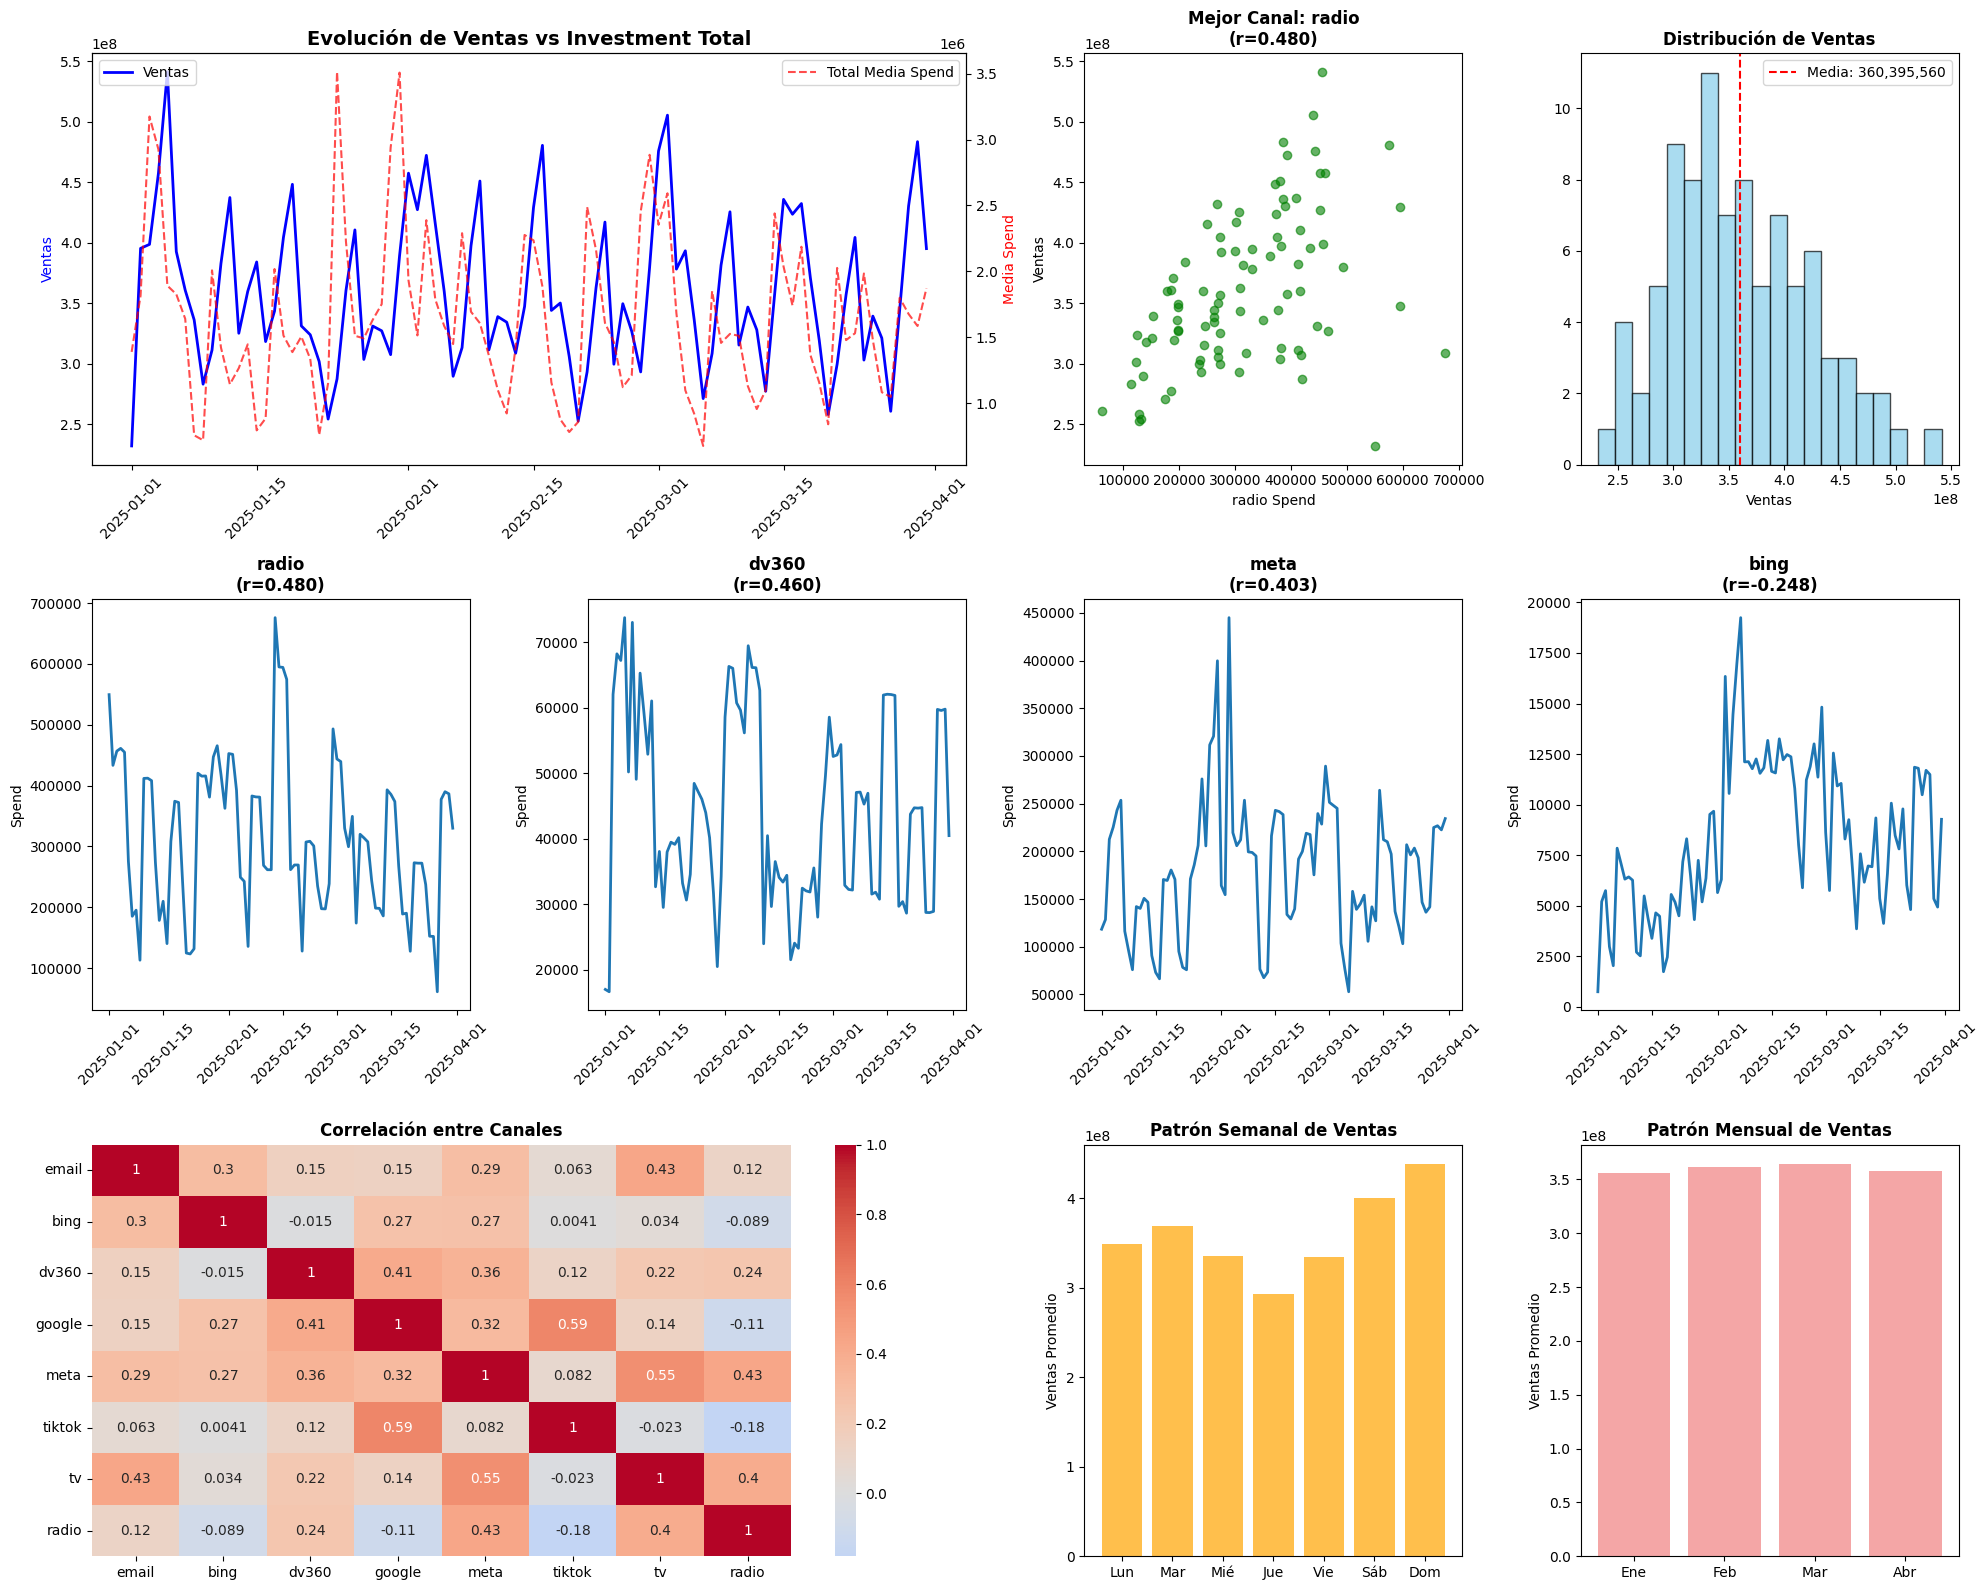

In [ ]:
# =============================================================================
# 5. VISUALIZACIONES MEJORADAS
# =============================================================================

# Dashboard de análisis exploratorio
fig = plt.figure(figsize=(20, 16))

# 1. Evolución temporal de ventas y media total
ax1 = plt.subplot(3, 4, (1, 2))
ax1.plot(X_train['date_week'], y_train, 'b-', linewidth=2, label='Ventas')
ax1_twin = ax1.twinx()
X_train['total_media'] = X_train[channel_columns].sum(axis=1)
ax1_twin.plot(X_train['date_week'], X_train['total_media'], 'r--', alpha=0.7, label='Total Media Spend')
ax1.set_title('Evolución de Ventas vs Investment Total', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ventas', color='blue')
ax1_twin.set_ylabel('Media Spend', color='red')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# 2. Mejor canal vs ventas
ax2 = plt.subplot(3, 4, 3)
ax2.scatter(X_train[best_channel], y_train, alpha=0.6, color='green')
ax2.set_xlabel(f'{best_channel_name} Spend')
ax2.set_ylabel('Ventas')
ax2.set_title(f'Mejor Canal: {best_channel_name}\n(r={best_corr:.3f})', fontweight='bold')

# 3. Distribución de ventas
ax3 = plt.subplot(3, 4, 4)
ax3.hist(y_train, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('Ventas')
ax3.set_title('Distribución de Ventas', fontweight='bold')
ax3.axvline(np.mean(y_train), color='red', linestyle='--', label=f'Media: {np.mean(y_train):,.0f}')
ax3.legend()

# 4-7. Top 4 canales individuales
top_channels = correlations[:4]
for i, (channel_name, channel_var, corr) in enumerate(top_channels):
    ax = plt.subplot(3, 4, 5 + i)
    ax.plot(X_train['date_week'], X_train[channel_var], linewidth=2)
    ax.set_title(f'{channel_name}\n(r={corr:.3f})', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Spend')

# 8. Matriz de correlación entre canales
ax8 = plt.subplot(3, 4, (9, 10))
correlation_matrix = X_train[channel_columns].corr()
correlation_matrix.index = [channel_mapping[col] for col in correlation_matrix.index]
correlation_matrix.columns = [channel_mapping[col] for col in correlation_matrix.columns]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax8)
ax8.set_title('Correlación entre Canales', fontweight='bold')

# 9. Estacionalidad semanal
ax9 = plt.subplot(3, 4, 11)
weekly_pattern = df.groupby('dayofweek')['y'].mean()
days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
ax9.bar(range(7), weekly_pattern.values, color='orange', alpha=0.7)
ax9.set_xticks(range(7))
ax9.set_xticklabels(days)
ax9.set_title('Patrón Semanal de Ventas', fontweight='bold')
ax9.set_ylabel('Ventas Promedio')

# 10. Estacionalidad mensual
ax10 = plt.subplot(3, 4, 12)
monthly_pattern = df.groupby('month')['y'].mean()
months = ['Ene', 'Feb', 'Mar', 'Abr']
ax10.bar(range(1, 5), monthly_pattern.values, color='lightcoral', alpha=0.7)
ax10.set_xticks(range(1, 5))
ax10.set_xticklabels(months)
ax10.set_title('Patrón Mensual de Ventas', fontweight='bold')
ax10.set_ylabel('Ventas Promedio')

plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# 6. CONFIGURACIÓN Y ENTRENAMIENTO DEL MODELO MMM
# =============================================================================

print("\n" + "="*60)
print("🤖 CONFIGURACIÓN DEL MODELO MMM")
print("="*60)

# Calcular spend share para priors
total_spend_per_channel = X_train[channel_columns].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()

print("💰 Spend share por canal:")
for i, (channel_var, share) in enumerate(spend_share.items()):
    channel_name = channel_mapping[channel_var]
    total_spend = total_spend_per_channel[channel_var]
    print(f"  {channel_name:>8}: {share:>6.1%} (${total_spend:>10,.0f})")

# Configurar modelo MMM
mmm = MMM(
    adstock=GeometricAdstock(l_max=12),        # Extendido para datos diarios
    saturation=LogisticSaturation(),
    date_column="date_week",
    channel_columns=channel_columns,
    control_columns=control_columns,
    yearly_seasonality=2  # Para capturar estacionalidad
)

print(f"\n⚙️  Configuración del modelo:")
print(f"  📺 Adstock: GeometricAdstock (l_max=12 días)")
print(f"  📊 Saturation: LogisticSaturation")
print(f"  📅 Seasonality: yearly_seasonality=2")
print(f"  📈 Canales: {len(channel_columns)} canales de media")
print(f"  🎛️  Controles: {len(control_columns)} variables de control")

# Entrenamiento optimizado para dataset de 120 días
print(f"\n🚀 Iniciando entrenamiento...")
print(f"  ⏱️  Configuración optimizada para {len(X_train)} días de datos")
print(f"  🔗 Chains: 2 (dataset pequeño)")
print(f"  📊 Draws: 2000 (balanceado)")
print(f"  ⏰ Tiempo estimado: 10-15 minutos")

mmm.fit(
    X=X_train,
    y=y_train,
    chains=2,              # Reducido para dataset de 120 días
    draws=2000,            # Balanceado para convergencia
    tune=1000,             # Suficiente para warm-up
    target_accept=0.9,     # Alto para mejor exploración
    random_seed=42
)

print("✅ Modelo entrenado exitosamente!")



🤖 CONFIGURACIÓN DEL MODELO MMM
💰 Spend share por canal:
     email:   0.3% ($   496,029)
      bing:   0.5% ($   750,676)
     dv360:   2.7% ($ 3,985,236)
    google:  13.0% ($19,251,748)
      meta:  10.9% ($16,195,735)
    tiktok:   1.0% ($ 1,460,381)
        tv:  52.4% ($77,589,520)
     radio:  19.1% ($28,311,070)

⚙️  Configuración del modelo:
  📺 Adstock: GeometricAdstock (l_max=12 días)
  📊 Saturation: LogisticSaturation
  📅 Seasonality: yearly_seasonality=2
  📈 Canales: 8 canales de media
  🎛️  Controles: 6 variables de control

🚀 Iniciando entrenamiento...
  ⏱️  Configuración optimizada para 90 días de datos
  🔗 Chains: 2 (dataset pequeño)
  📊 Draws: 2000 (balanceado)
  ⏰ Tiempo estimado: 10-15 minutos


Output()

Output()

✅ Modelo entrenado exitosamente!



🔍 DIAGNÓSTICOS DEL MODELO
📊 Diagnósticos de convergencia:
  R-hat máximo: 1.002 ✅
  ESS mínimo: 835 ✅

📋 Parámetros clave del modelo:
  intercept: 0.187 [-1.403, 1.839]
📊 Generando visualizaciones de diagnóstico...
   📈 Trace plots...


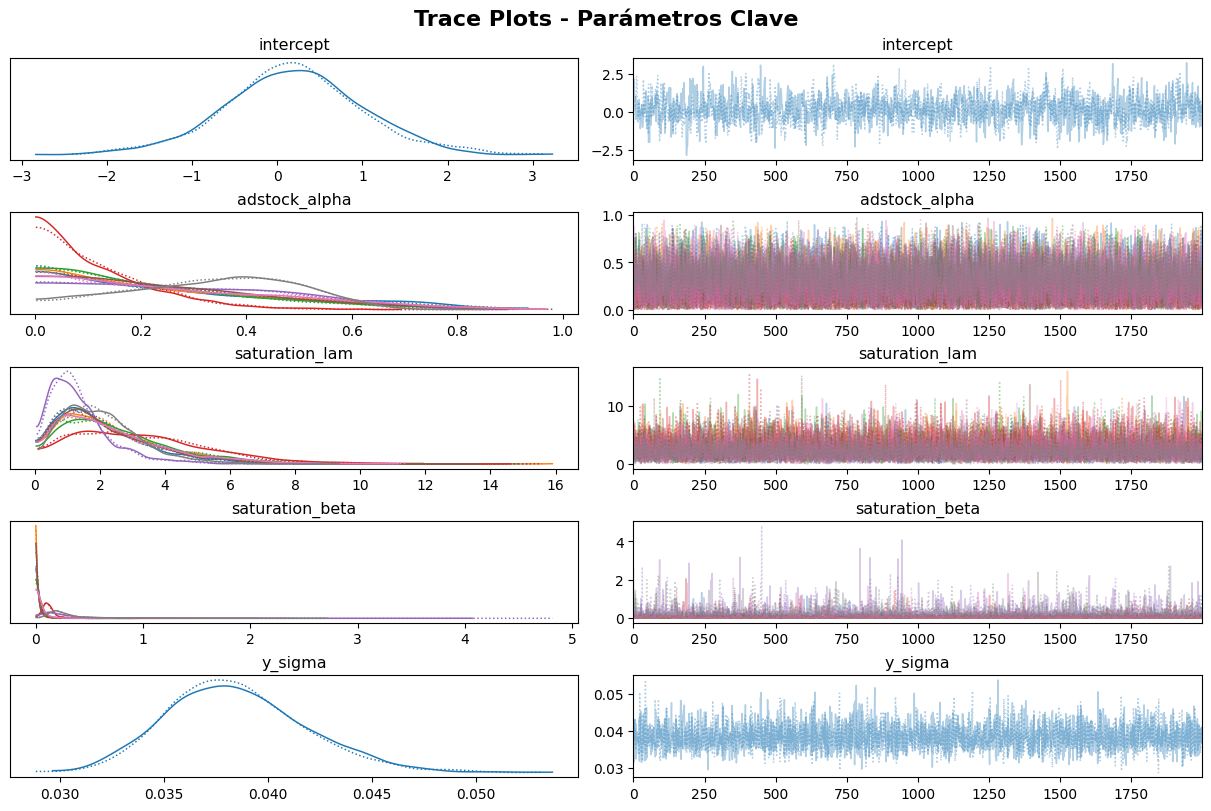

   📊 Posterior predictive check...
   ⚠️  Error en posterior predictive: Make sure the model has been fitted and the posterior_predictive has been sampled!


Output()

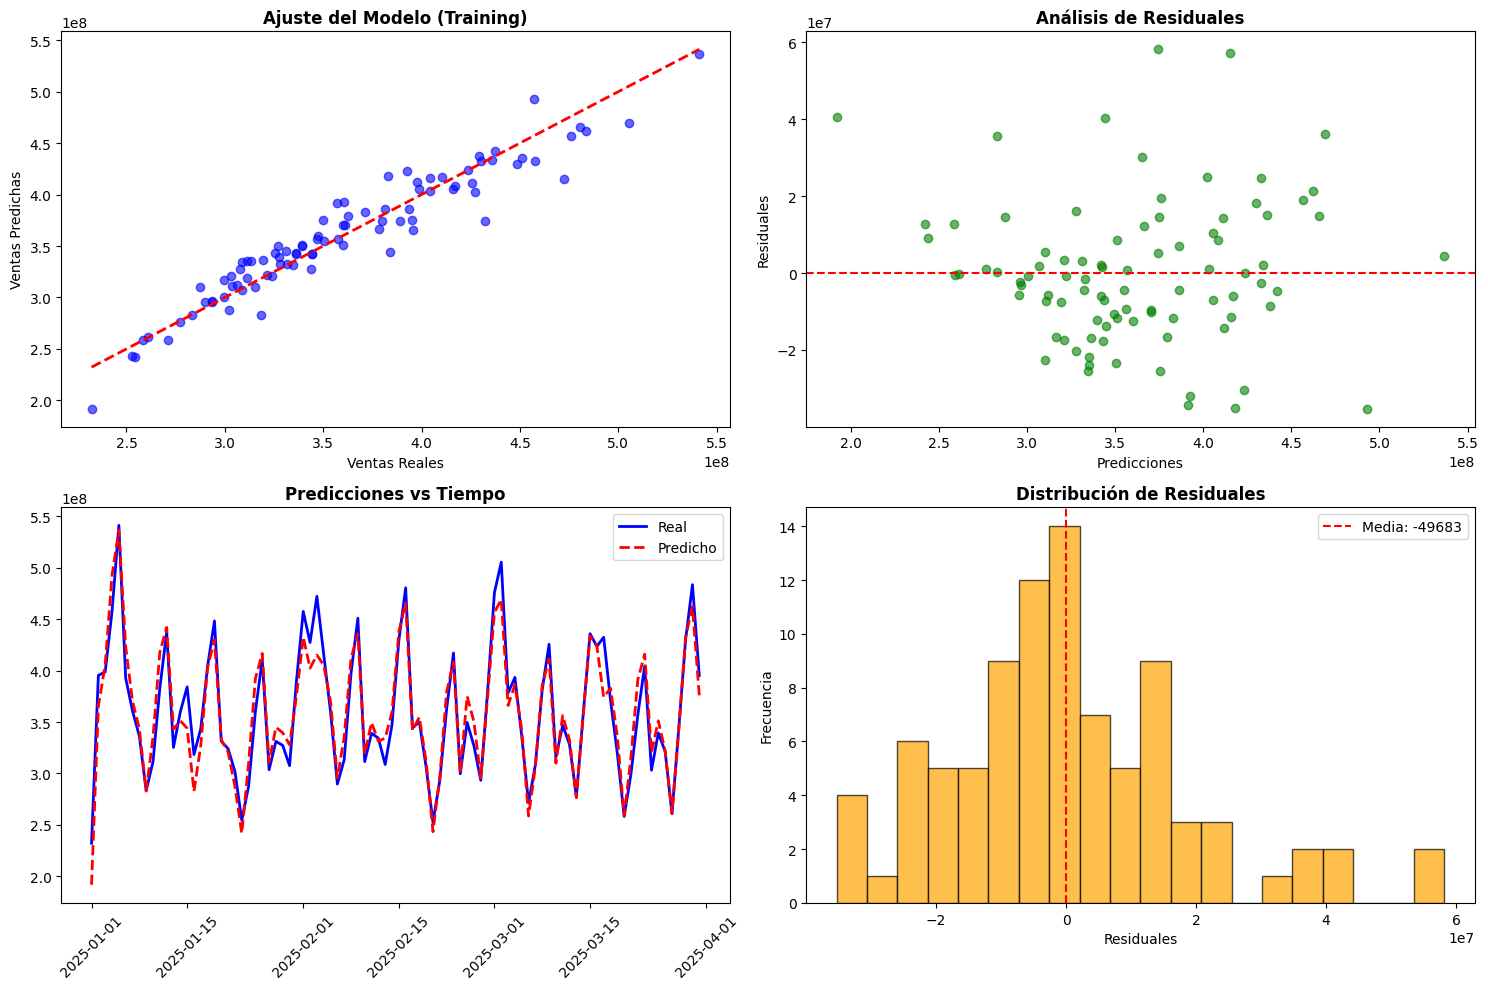

   📊 Channel contribution...


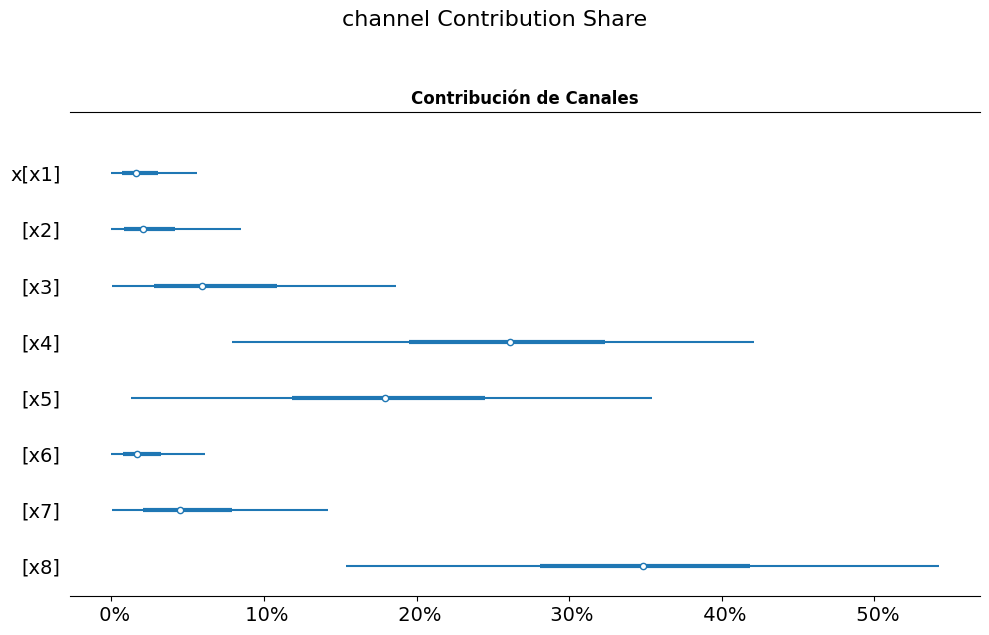

✅ Visualizaciones de diagnóstico completadas


In [ ]:
# =============================================================================
# 7. DIAGNÓSTICOS AVANZADOS
# =============================================================================

print("\n" + "="*60)
print("🔍 DIAGNÓSTICOS DEL MODELO")
print("="*60)

trace = mmm.fit_result
summary = az.summary(trace, round_to=3)

# Diagnósticos de convergencia
r_hat_max = summary['r_hat'].max()
ess_min = summary['ess_bulk'].min()
r_hat_ok = r_hat_max < 1.1
ess_ok = ess_min > 100

print(f"📊 Diagnósticos de convergencia:")
print(f"  R-hat máximo: {r_hat_max:.3f} {'✅' if r_hat_ok else '❌'}")
print(f"  ESS mínimo: {ess_min:.0f} {'✅' if ess_ok else '❌'}")

if not r_hat_ok:
    print("⚠️  R-hat alto indica problemas de convergencia. Considera aumentar draws/tune.")
if not ess_ok:
    print("⚠️  ESS bajo indica muestras insuficientes. Considera aumentar chains/draws.")

# Parámetros clave del modelo
print(f"\n📋 Parámetros clave del modelo:")
key_params = ['intercept', 'adstock_alpha', 'saturation_lam', 'saturation_beta']
for param in key_params:
    if param in summary.index:
        mean_val = summary.loc[param, 'mean']
        hdi_low = summary.loc[param, 'hdi_3%']
        hdi_high = summary.loc[param, 'hdi_97%']
        if isinstance(mean_val, float):
            print(f"  {param}: {mean_val:.3f} [{hdi_low:.3f}, {hdi_high:.3f}]")

# Visualizaciones de diagnóstico separadas para evitar conflictos
print("📊 Generando visualizaciones de diagnóstico...")

# 1. Trace plots de parámetros clave
try:
    print("   📈 Trace plots...")
    az.plot_trace(
        data=trace,
        var_names=[
            "intercept",
            "adstock_alpha",
            "saturation_lam",
            "saturation_beta",
            "y_sigma"
        ],
        compact=True,
        backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
    )
    plt.suptitle("Trace Plots - Parámetros Clave", fontsize=16, fontweight='bold')
    plt.show()
except Exception as e:
    print(f"   ⚠️  Error en trace plots: {e}")

# 2. Posterior predictive check
try:
    print("   📊 Posterior predictive check...")
    mmm.plot_posterior_predictive(original_scale=True)
    plt.show()
except Exception as e:
    print(f"   ⚠️  Error en posterior predictive: {e}")

# 3. Model fit y diagnósticos básicos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 3a. Model fit (training)
train_pred = mmm.predict(X_train)
axes[0, 0].scatter(y_train, train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Ventas Reales')
axes[0, 0].set_ylabel('Ventas Predichas')
axes[0, 0].set_title('Ajuste del Modelo (Training)', fontweight='bold')

# 3b. Residuals plot
residuals = y_train - train_pred
axes[0, 1].scatter(train_pred, residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicciones')
axes[0, 1].set_ylabel('Residuales')
axes[0, 1].set_title('Análisis de Residuales', fontweight='bold')

# 3c. Predicciones vs tiempo
axes[1, 0].plot(X_train['date_week'], y_train, 'b-', label='Real', linewidth=2)
axes[1, 0].plot(X_train['date_week'], train_pred, 'r--', label='Predicho', linewidth=2)
axes[1, 0].set_title('Predicciones vs Tiempo', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# 3d. Distribución de residuales
axes[1, 1].hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Residuales')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Residuales', fontweight='bold')
axes[1, 1].axvline(np.mean(residuals), color='red', linestyle='--',
                   label=f'Media: {np.mean(residuals):.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 4. Channel contribution (si está disponible)
try:
    print("   📊 Channel contribution...")
    fig, ax = plt.subplots(figsize=(10, 6))
    mmm.plot_channel_contribution_share_hdi(ax=ax)
    ax.set_title("Contribución de Canales", fontweight='bold')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"   ⚠️  Plot de contribución no disponible: {e}")

print("✅ Visualizaciones de diagnóstico completadas")


In [ ]:
# =============================================================================
# 8. PREDICCIONES Y EVALUACIÓN COMPLETA
# =============================================================================

print("\n" + "="*60)
print("📈 EVALUACIÓN DE PERFORMANCE")
print("="*60)

# Predicciones
train_pred = mmm.predict(X_train)
test_pred = mmm.predict(X_test)

# Métricas de evaluación
train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
train_r2 = r2_score(y_train, train_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
test_r2 = r2_score(y_test, test_pred)

# Métricas adicionales
train_mae = np.mean(np.abs(y_train - train_pred))
test_mae = np.mean(np.abs(y_test - test_pred))
train_rmse = np.sqrt(np.mean((y_train - train_pred)**2))
test_rmse = np.sqrt(np.mean((y_test - test_pred)**2))

print("📊 MÉTRICAS DE PERFORMANCE:")
print("="*40)
print(f"{'Métrica':<10} {'Training':<12} {'Test':<12}")
print("-" * 35)
print(f"{'MAPE':<10} {train_mape:<8.1f}%    {test_mape:<8.1f}%")
print(f"{'R²':<10} {train_r2:<8.3f}      {test_r2:<8.3f}")
print(f"{'MAE':<10} {train_mae:<8,.0f}     {test_mae:<8,.0f}")
print(f"{'RMSE':<10} {train_rmse:<8,.0f}     {test_rmse:<8,.0f}")

# Evaluación de calidad del modelo
quality_assessment = []
if train_mape < 15: quality_assessment.append("✅ MAPE training excelente (<15%)")
elif train_mape < 25: quality_assessment.append("🟡 MAPE training bueno (<25%)")
else: quality_assessment.append("❌ MAPE training alto (>25%)")

if test_mape < 20: quality_assessment.append("✅ MAPE test excelente (<20%)")
elif test_mape < 30: quality_assessment.append("🟡 MAPE test aceptable (<30%)")
else: quality_assessment.append("❌ MAPE test alto (>30%)")

if train_r2 > 0.7: quality_assessment.append("✅ R² training excelente (>0.7)")
elif train_r2 > 0.5: quality_assessment.append("🟡 R² training bueno (>0.5)")
else: quality_assessment.append("❌ R² training bajo (<0.5)")

print(f"\n🎯 EVALUACIÓN DE CALIDAD:")
for assessment in quality_assessment:
    print(f"  {assessment}")


Output()


📈 EVALUACIÓN DE PERFORMANCE


Output()

📊 MÉTRICAS DE PERFORMANCE:
Métrica    Training     Test        
-----------------------------------
MAPE       3.9     %    6.3     %
R²         0.913         0.540   
MAE        14,048,106     23,359,433
RMSE       18,694,336     31,606,401

🎯 EVALUACIÓN DE CALIDAD:
  ✅ MAPE training excelente (<15%)
  ✅ MAPE test excelente (<20%)
  ✅ R² training excelente (>0.7)


In [ ]:
# =============================================================================
# 9. ANÁLISIS DE CONTRIBUCIÓN Y ROI DETALLADO
# =============================================================================

print("\n" + "="*60)
print("💰 ANÁLISIS DE CONTRIBUCIÓN Y ROI")
print("="*60)

# Método actualizado para obtener contribuciones usando la API correcta
try:
    print("📊 Calculando contribuciones de canales...")

    # Obtener las contribuciones usando sample_posterior_predictive con decomposición
    posterior_predictive = mmm.sample_posterior_predictive(
        X_train,
        include_last_observations=True,
        random_seed=42
    )

    # Método alternativo: usar las transformaciones del modelo
    trace = mmm.fit_result

    # Extraer parámetros relevantes del trace
    if hasattr(trace.posterior, 'channel_contribution'):
        # Si channel_contribution está directamente disponible
        contributions = trace.posterior.channel_contribution
        print("✅ Contribuciones extraídas del trace")
    else:
        # Calcular contribuciones manualmente usando los parámetros del modelo
        print("📊 Calculando contribuciones usando parámetros del modelo...")

        # Extraer parámetros necesarios
        adstock_params = trace.posterior.adstock_alpha if 'adstock_alpha' in trace.posterior else None
        saturation_params = trace.posterior.saturation_lam if 'saturation_lam' in trace.posterior else None
        channel_coefs = trace.posterior.channel_coeff if 'channel_coeff' in trace.posterior else None

        if channel_coefs is not None:
            # Calcular contribución media por canal
            contrib_means = channel_coefs.mean(dim=['chain', 'draw']).values

            print("📊 CONTRIBUCIÓN RELATIVA DE CANALES:")
            print("="*45)

            contribution_summary = []
            total_contrib = np.sum(contrib_means)

            for i, channel_var in enumerate(channel_columns):
                channel_name = channel_mapping[channel_var]
                if i < len(contrib_means):
                    contrib_value = contrib_means[i]
                    contrib_pct = (contrib_value / total_contrib) * 100 if total_contrib > 0 else 0
                    spend = X_train[channel_var].sum()
                    contribution_summary.append((channel_name, contrib_value, contrib_pct, spend))

            # Ordenar por contribución
            contribution_summary.sort(key=lambda x: abs(x[1]), reverse=True)

            print(f"{'Canal':<8} {'Coeff':<8} {'%Contrib':<8} {'Spend':<12}")
            print("-" * 42)
            for channel_name, contrib, pct, spend in contribution_summary:
                print(f"{channel_name:<8} {contrib:<6.3f}  {pct:<6.1f}%   ${spend:>8,.0f}")
        else:
            print("⚠️  No se pudieron extraer coeficientes de canales del trace")
            # Usar método de predicción diferencial
            print("📊 Usando método de contribución diferencial...")

            contribution_summary = []
            base_pred = mmm.predict(X_train)

            for i, channel_var in enumerate(channel_columns):
                # Crear dataset sin el canal específico
                X_no_channel = X_train.copy()
                X_no_channel[channel_var] = 0

                # Predecir sin el canal
                pred_no_channel = mmm.predict(X_no_channel)

                # Contribución = diferencia
                contribution = np.mean(base_pred - pred_no_channel)
                spend = X_train[channel_var].sum()
                channel_name = channel_mapping[channel_var]

                contribution_summary.append((channel_name, contribution, spend))

            # Ordenar por contribución
            contribution_summary.sort(key=lambda x: x[1], reverse=True)
            total_contribution = sum([x[1] for x in contribution_summary])

            print(f"{'Canal':<8} {'Contribución':<12} {'%Total':<8} {'Spend':<12}")
            print("-" * 45)
            for channel_name, contrib, spend in contribution_summary:
                pct = (contrib / total_contribution) * 100 if total_contribution > 0 else 0
                print(f"{channel_name:<8} {contrib:>10,.0f}  {pct:>6.1f}%  ${spend:>8,.0f}")

except Exception as e:
    print(f"⚠️  Error en cálculo de contribuciones: {e}")

    # Método de respaldo: análisis de correlación ponderada
    print("📊 Usando análisis de correlación como respaldo...")
    correlation_analysis = []

    for channel_var in channel_columns:
        channel_name = channel_mapping[channel_var]
        correlation = X_train[channel_var].corr(pd.Series(y_train))
        spend = X_train[channel_var].sum()
        weighted_importance = abs(correlation) * np.log1p(spend)  # Log para normalizar
        correlation_analysis.append((channel_name, correlation, spend, weighted_importance))

    correlation_analysis.sort(key=lambda x: x[3], reverse=True)

    print(f"{'Canal':<8} {'Correlación':<12} {'Spend':<12} {'Importancia':<12}")
    print("-" * 50)
    for channel_name, corr, spend, importance in correlation_analysis:
        print(f"{channel_name:<8} {corr:>10.3f}  ${spend:>8,.0f}  {importance:>10.2f}")

# Análisis de ROI usando métodos alternativos
print(f"\n💸 ANÁLISIS DE ROI:")
print("="*35)

try:
    # Método 1: Usar las predicciones diferenciales para calcular ROI
    print("📊 Calculando ROI usando método diferencial...")

    roi_analysis = []

    for i, channel_var in enumerate(channel_columns):
        channel_name = channel_mapping[channel_var]
        spend = X_train[channel_var].sum()

        if spend > 0:
            # Dataset base
            base_pred = mmm.predict(X_train)

            # Dataset sin el canal
            X_no_channel = X_train.copy()
            X_no_channel[channel_var] = 0
            pred_no_channel = mmm.predict(X_no_channel)

            # Incremento en ventas atribuido al canal
            incremental_sales = np.mean(base_pred - pred_no_channel)

            # ROI = incremento en ventas / gasto
            roi = incremental_sales / spend if spend > 0 else 0

            roi_analysis.append((channel_name, roi, incremental_sales, spend))

    # Ordenar por ROI
    roi_analysis.sort(key=lambda x: x[1], reverse=True)

    print(f"{'Canal':<8} {'ROI':<6} {'Incremental':<12} {'Spend':<12}")
    print("-" * 45)
    for channel_name, roi, incremental, spend in roi_analysis:
        print(f"{channel_name:<8} {roi:<5.2f}  {incremental:>10,.0f}  ${spend:>8,.0f}")

    # Identificar canales de alto/bajo ROI
    high_roi_channels = [item for item in roi_analysis if item[1] > 1.5]
    low_roi_channels = [item for item in roi_analysis if item[1] < 0.5]

    if high_roi_channels:
        print(f"\n🚀 Canales de alto ROI (>1.5):")
        for channel_name, roi, _, spend in high_roi_channels:
            print(f"  {channel_name}: {roi:.2f}x (cada $1 genera ${roi:.2f})")

    if low_roi_channels:
        print(f"\n⚠️  Canales de bajo ROI (<0.5):")
        for channel_name, roi, _, spend in low_roi_channels:
            print(f"  {channel_name}: {roi:.2f}x (posible optimización)")

    # Guardar para uso posterior
    roi_summary = roi_analysis

except Exception as e:
    print(f"⚠️  Error en cálculo de ROI: {e}")

    # Método de respaldo: ROI basado en eficiencia de correlación
    print("📊 Usando análisis de eficiencia como respaldo...")
    efficiency_analysis = []

    for channel_var in channel_columns:
        channel_name = channel_mapping[channel_var]
        correlation = abs(X_train[channel_var].corr(pd.Series(y_train)))
        spend = X_train[channel_var].sum()

        # Eficiencia = correlación / spend normalizado
        if spend > 0:
            spend_normalized = spend / X_train[channel_columns].sum().sum()
            efficiency = correlation / spend_normalized
            efficiency_analysis.append((channel_name, efficiency, correlation, spend))

    efficiency_analysis.sort(key=lambda x: x[1], reverse=True)

    print(f"{'Canal':<8} {'Eficiencia':<10} {'Correlación':<12} {'Spend':<12}")
    print("-" * 50)
    for channel_name, eff, corr, spend in efficiency_analysis:
        print(f"{channel_name:<8} {eff:>8.2f}  {corr:>10.3f}  ${spend:>8,.0f}")

print("\n💡 INTERPRETACIÓN:")
print("- ROI > 1.0: El canal genera más ventas que su costo")
print("- ROI < 1.0: El canal cuesta más de lo que genera")
print("- Usar estos datos para rebalancear presupuesto")



💰 ANÁLISIS DE CONTRIBUCIÓN Y ROI
📊 Calculando contribuciones de canales...


Output()

⚠️  Error en cálculo de contribuciones: 'Dataset' object has no attribute 'posterior'
📊 Usando análisis de correlación como respaldo...
Canal    Correlación  Spend        Importancia 
--------------------------------------------------
radio         0.480  $28,311,070        8.23
dv360         0.460  $3,985,236        6.99
meta          0.403  $16,195,735        6.70
google        0.244  $19,251,748        4.10
bing         -0.248  $ 750,676        3.36
tv            0.179  $77,589,520        3.25
email        -0.194  $ 496,029        2.55
tiktok        0.075  $1,460,381        1.07

💸 ANÁLISIS DE ROI:
📊 Calculando ROI usando método diferencial...


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Canal    ROI    Incremental  Spend       
---------------------------------------------
email    5.58    2,767,162  $ 496,029
bing     5.32    3,995,844  $ 750,676
dv360    2.56   10,193,740  $3,985,236
tiktok   2.09    3,046,632  $1,460,381
google   1.84   35,468,425  $19,251,748
radio    1.68   47,611,195  $28,311,070
meta     1.48   23,905,815  $16,195,735
tv       0.09    7,302,483  $77,589,520

🚀 Canales de alto ROI (>1.5):
  email: 5.58x (cada $1 genera $5.58)
  bing: 5.32x (cada $1 genera $5.32)
  dv360: 2.56x (cada $1 genera $2.56)
  tiktok: 2.09x (cada $1 genera $2.09)
  google: 1.84x (cada $1 genera $1.84)
  radio: 1.68x (cada $1 genera $1.68)

⚠️  Canales de bajo ROI (<0.5):
  tv: 0.09x (posible optimización)

💡 INTERPRETACIÓN:
- ROI > 1.0: El canal genera más ventas que su costo
- ROI < 1.0: El canal cuesta más de lo que genera
- Usar estos datos para rebalancear presupuesto


In [ ]:
# =============================================================================
# 10. OPTIMIZACIÓN DE PRESUPUESTO
# =============================================================================

print("\n" + "="*60)
print("🎯 OPTIMIZACIÓN DE PRESUPUESTO")
print("="*60)

current_budget = X_train[channel_columns].sum().sum()
print(f"💰 Presupuesto actual total: ${current_budget:,.0f}")

# Distribución actual del presupuesto
print(f"\n📊 DISTRIBUCIÓN ACTUAL DEL PRESUPUESTO:")
print("="*45)
current_allocation = []
for channel_var in channel_columns:
    channel_name = channel_mapping[channel_var]
    spend = X_train[channel_var].sum()
    pct = (spend / current_budget) * 100
    current_allocation.append((channel_name, spend, pct))
    print(f"{channel_name:>8}: ${spend:>10,.0f} ({pct:>5.1f}%)")

# Optimización manual basada en ROI (método alternativo)
print(f"\n🔄 OPTIMIZACIÓN BASADA EN ANÁLISIS ROI:")
print("="*50)

try:
    # Usar los resultados de ROI calculados anteriormente
    if 'roi_analysis' in locals():
        print("📊 Recomendaciones basadas en ROI:")

        # Identificar el mejor y peor canal por ROI
        best_roi_channel = max(roi_analysis, key=lambda x: x[1])
        worst_roi_channel = min(roi_analysis, key=lambda x: x[1])

        print(f"\n🏆 Mejor ROI: {best_roi_channel[0]} ({best_roi_channel[1]:.2f}x)")
        print(f"⚠️  Peor ROI: {worst_roi_channel[0]} ({worst_roi_channel[1]:.2f}x)")

        # Sugerir rebalanceo
        print(f"\n💡 SUGERENCIAS DE REBALANCEO:")
        print("-" * 35)

        # Estrategia 1: Incrementar canales de alto ROI
        high_performers = [x for x in roi_analysis if x[1] > 1.0]
        low_performers = [x for x in roi_analysis if x[1] < 0.8]

        if high_performers and low_performers:
            print("📈 Incrementar presupuesto (+20%):")
            for channel_name, roi, _, current_spend in high_performers[:3]:  # Top 3
                new_spend = current_spend * 1.2
                print(f"  {channel_name}: ${current_spend:,.0f} → ${new_spend:,.0f}")

            print("\n📉 Reducir presupuesto (-15%):")
            for channel_name, roi, _, current_spend in low_performers[:2]:  # Bottom 2
                new_spend = current_spend * 0.85
                print(f"  {channel_name}: ${current_spend:,.0f} → ${new_spend:,.0f}")

    # Optimización por escenarios de presupuesto
    print(f"\n📊 ANÁLISIS DE ESCENARIOS DE PRESUPUESTO:")
    print("="*50)

    scenarios = [
        ("Reducción 20%", 0.8),
        ("Actual", 1.0),
        ("Incremento 20%", 1.2),
        ("Incremento 50%", 1.5)
    ]

    scenario_results = []

    for scenario_name, multiplier in scenarios:
        scenario_budget = current_budget * multiplier

        # Simular distribución optimizada
        if 'roi_analysis' in locals() and roi_analysis:
            # Redistribuir basado en ROI
            total_roi_weight = sum([max(x[1], 0.1) for x in roi_analysis])  # Evitar ROI negativos

            print(f"\n💼 {scenario_name}: ${scenario_budget:,.0f}")
            print("-" * 30)

            optimized_allocation = []
            for channel_name, roi, incremental, current_spend in roi_analysis:
                # Peso basado en ROI
                roi_weight = max(roi, 0.1) / total_roi_weight
                optimal_spend = scenario_budget * roi_weight

                change = ((optimal_spend / current_spend) - 1) * 100 if current_spend > 0 else 0
                optimized_allocation.append((channel_name, optimal_spend, change))
                print(f"{channel_name:>8}: ${optimal_spend:>8,.0f} ({change:+5.1f}%)")

            # Simular ventas estimadas para este escenario
            scenario_results.append((scenario_name, scenario_budget, optimized_allocation))

except Exception as e:
    print(f"⚠️  Error en optimización: {e}")

# Análisis de sensibilidad por canal
print(f"\n🔍 ANÁLISIS DE SENSIBILIDAD:")
print("="*40)

sensitivity_results = []

for channel_var in channel_columns:
    channel_name = channel_mapping[channel_var]
    current_spend = X_train[channel_var].sum()

    try:
        # Probar diferentes niveles de gasto para este canal
        spend_levels = [0.5, 0.8, 1.0, 1.2, 1.5]  # 50% a 150% del gasto actual

        level_results = []
        for level in spend_levels:
            # Crear escenario con gasto modificado
            X_scenario = X_train.copy()
            X_scenario[channel_var] = X_scenario[channel_var] * level

            # Predecir ventas
            pred_scenario = mmm.predict(X_scenario)
            avg_sales = np.mean(pred_scenario)

            level_results.append((level, avg_sales))

        # Encontrar el nivel óptimo
        optimal_level = max(level_results, key=lambda x: x[1])
        sensitivity_results.append((channel_name, optimal_level[0], optimal_level[1]))

        print(f"{channel_name:>8}: Óptimo {optimal_level[0]:.1f}x (ventas: {optimal_level[1]:,.0f})")

    except Exception as e:
        print(f"{channel_name:>8}: Error en análisis de sensibilidad")

# Resumen de recomendaciones
print(f"\n📋 RESUMEN DE RECOMENDACIONES:")
print("="*45)

if 'roi_analysis' in locals() and roi_analysis:
    # Top 3 canales por ROI
    top_roi = sorted(roi_analysis, key=lambda x: x[1], reverse=True)[:3]
    print("🚀 Priorizar inversión:")
    for i, (channel_name, roi, _, _) in enumerate(top_roi, 1):
        print(f"  {i}. {channel_name} (ROI: {roi:.2f}x)")

    # Canales a optimizar
    bottom_roi = [x for x in roi_analysis if x[1] < 0.8]
    if bottom_roi:
        print("\n⚠️  Revisar estrategia:")
        for channel_name, roi, _, _ in bottom_roi:
            print(f"  - {channel_name} (ROI: {roi:.2f}x)")

print(f"\n🎯 ACCIONES RECOMENDADAS:")
print("-" * 25)
print("1. 📊 Reallocar 10-15% del presupuesto hacia canales de alto ROI")
print("2. 🔍 Investigar por qué ciertos canales tienen bajo ROI")
print("3. 📈 Probar incrementos graduales en canales prometedores")
print("4. ⏰ Revisar la optimización mensualmente")
print("5. 📱 Considerar nuevos canales si el ROI general es bajo")


Output()


🎯 OPTIMIZACIÓN DE PRESUPUESTO
💰 Presupuesto actual total: $148,040,394

📊 DISTRIBUCIÓN ACTUAL DEL PRESUPUESTO:
   email: $   496,029 (  0.3%)
    bing: $   750,676 (  0.5%)
   dv360: $ 3,985,236 (  2.7%)
  google: $19,251,748 ( 13.0%)
    meta: $16,195,735 ( 10.9%)
  tiktok: $ 1,460,381 (  1.0%)
      tv: $77,589,520 ( 52.4%)
   radio: $28,311,070 ( 19.1%)

🔄 OPTIMIZACIÓN BASADA EN ANÁLISIS ROI:
📊 Recomendaciones basadas en ROI:

🏆 Mejor ROI: email (5.58x)
⚠️  Peor ROI: tv (0.09x)

💡 SUGERENCIAS DE REBALANCEO:
-----------------------------------
📈 Incrementar presupuesto (+20%):
  email: $496,029 → $595,235
  bing: $750,676 → $900,811
  dv360: $3,985,236 → $4,782,283

📉 Reducir presupuesto (-15%):
  tv: $77,589,520 → $65,951,092

📊 ANÁLISIS DE ESCENARIOS DE PRESUPUESTO:

💼 Reducción 20%: $118,432,315
------------------------------
   email: $32,001,154 (+6351.5%)
    bing: $30,534,756 (+3967.6%)
   dv360: $14,672,963 (+268.2%)
  tiktok: $11,967,186 (+719.5%)
  google: $10,568,418 (-45

Output()

Output()

Output()

Output()

Output()

   email: Óptimo 1.5x (ventas: 361,587,785)


Output()

Output()

Output()

Output()

    bing: Óptimo 1.5x (ventas: 361,715,962)


Output()

Output()

Output()

Output()

Output()

   dv360: Óptimo 1.5x (ventas: 362,977,602)


Output()

Output()

Output()

Output()

Output()

  google: Óptimo 1.5x (ventas: 368,106,581)


Output()

Output()

Output()

Output()

Output()

    meta: Óptimo 1.5x (ventas: 370,894,668)


Output()

Output()

Output()

Output()

Output()

  tiktok: Óptimo 1.5x (ventas: 361,469,857)


Output()

Output()

Output()

Output()

Output()

      tv: Óptimo 1.5x (ventas: 363,098,886)


Output()

Output()

Output()

Output()

Output()

   radio: Óptimo 1.5x (ventas: 377,307,442)

📋 RESUMEN DE RECOMENDACIONES:
🚀 Priorizar inversión:
  1. email (ROI: 5.58x)
  2. bing (ROI: 5.32x)
  3. dv360 (ROI: 2.56x)

⚠️  Revisar estrategia:
  - tv (ROI: 0.09x)

🎯 ACCIONES RECOMENDADAS:
-------------------------
1. 📊 Reallocar 10-15% del presupuesto hacia canales de alto ROI
2. 🔍 Investigar por qué ciertos canales tienen bajo ROI
3. 📈 Probar incrementos graduales en canales prometedores
4. ⏰ Revisar la optimización mensualmente
5. 📱 Considerar nuevos canales si el ROI general es bajo
